# Audio Spoofing Detection Notebook

This notebook aims to detect spoofed audio using various machine learning models. It covers data loading, preprocessing, model training, evaluation, and plotting.

In [1]:
# Setup and Initial Imports
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm

# Add the project root folder to PYTHONPATH
sys.path.append(os.path.abspath('..'))

## Import Machine Learning Libraries

In this cell, we import the necessary libraries for machine learning and data processing.

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, det_curve
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit

# Filterbanks 
Train using Filterbanks Features

## Define File Paths

Define the paths for the processed features and protocol file. Make sure to adjust these paths as needed.

In [3]:
TEST_FEATURES_FB  = "../data/processed/filterbanks_features_ASVspoof2021_DF_eval_part00.pkl"
TRAIN_FEATURES_FB = "../data/processed/filterbanks_features.pkl"
TEST_PROTOCOL  = "../data/raw/DF-keys-full/keys/DF/CM/trial_metadata.txt"
TRAIN_PROTOCOL = "../data/raw/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"

## Load Features

Load the feature data from the pickle file.

In [4]:
with open(TRAIN_FEATURES_FB, 'rb') as f:
    train_data = pickle.load(f)
with open(TEST_FEATURES_FB, 'rb') as f:
    test_data = pickle.load(f)

In [5]:
len(train_data), len(test_data)

(25380, 152955)

## Read Protocol Files

Define a function to read the protocol file, which maps audio files to labels, and load the DataFrame for train and test.

In [6]:
! cat '../data/raw/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt' | head -5

LA_0079 LA_T_1138215 - - bonafide
LA_0079 LA_T_1271820 - - bonafide
LA_0079 LA_T_1272637 - - bonafide
LA_0079 LA_T_1276960 - - bonafide
LA_0079 LA_T_1341447 - - bonafide
cat: write error: Broken pipe


In [7]:
def read_cm_protocol_train(filepath: str) -> pd.DataFrame:
    """
    Reads the ASVspoof2019 LA train protocol file and returns a DataFrame with:
      - speaker_id : speaker identifier (e.g. LA_0079)
      - audio_file : trial identifier (e.g. LA_T_1138215)
      - system_id  : system placeholder ('-')
      - key        : bonafide/spoof label

    Args:
        filepath (str): path to the ASVspoof2019.LA.cm.train.trn.txt file.

    Returns:
        pd.DataFrame: columns = [speaker_id, audio_file, system_id, key]
    """
    # the file has 5 whitespace-separated fields, the 4th is unused ('-')
    col_names = ["speaker_id", "audio_file", "system_id", "unused", "key"]
    df = pd.read_csv(
        filepath,
        sep=r"\s+",
        names=col_names,
        engine="python",
        index_col=False
    )
    df = df.drop(columns=["unused"])
    return df

# Usage example:
train_df = read_cm_protocol_train(TRAIN_PROTOCOL)
print("Train Protocol (first 5 rows):")
train_df.head()


Train Protocol (first 5 rows):


,speaker_id,audio_file,system_id,key
0,LA_0079,LA_T_1138215,-,bonafide
1,LA_0079,LA_T_1271820,-,bonafide
2,LA_0079,LA_T_1272637,-,bonafide
3,LA_0079,LA_T_1276960,-,bonafide
4,LA_0079,LA_T_1341447,-,bonafide


In [8]:
! cat '../data/raw/DF-keys-full/keys/DF/CM/trial_metadata.txt' | head -5

LA_0023 DF_E_2000011 nocodec asvspoof A14 spoof notrim progress traditional_vocoder - - - -
TEF2 DF_E_2000013 low_m4a vcc2020 Task1-team20 spoof notrim eval neural_vocoder_nonautoregressive Task1 team20 FF E
TGF1 DF_E_2000024 mp3m4a vcc2020 Task2-team12 spoof notrim eval traditional_vocoder Task2 team12 FF G
LA_0043 DF_E_2000026 mp3m4a asvspoof A09 spoof notrim eval traditional_vocoder - - - -
LA_0021 DF_E_2000027 mp3m4a asvspoof A12 spoof notrim eval neural_vocoder_autoregressive - - - -
cat: write error: Broken pipe


In [9]:
def read_cm_protocol_test(filepath: str) -> pd.DataFrame:
    """
    Reads a CM protocol file and returns a DataFrame with the following columns:
      - speaker_id     : speaker identifier (e.g., LA_0023)
      - trial_id       : trial identifier (e.g., DF_E_2000011)
      - codec          : compression codec (e.g., nocodec, low_mp3, high_ogg, etc.)
      - data_source    : data origin (asvspoof, vcc2018, vcc2020)
      - attack_id      : spoofing attack code (A07–A19)
      - key            : trial label (bonafide or spoof)
      - trim           : speech trimming flag (notrim or trim)
      - subset         : subset name (eval, progress, hidden)
      - vocoder_type   : vocoder category
    The remaining four fields (always “-”) are discarded.
    """
    # Define all 13 column names but only keep the first 9
    column_names = [
        "speaker_id", "trial_id", "codec", "data_source", "attack_id",
        "key", "trim", "subset", "vocoder_type",
        "unused1", "unused2", "unused3", "unused4"
    ]
    
    # Read using any amount of whitespace as delimiter
    df = pd.read_csv(
        filepath,
        sep=r"\s+",
        names=column_names,
        engine="python",
        index_col=False
    )
    
    # Drop the unused placeholder columns
    df = df.drop(columns=["unused1", "unused2", "unused3", "unused4"])
    
    return df

# Example usage:
test_df = read_cm_protocol_test(TEST_PROTOCOL)
test_df.head()

,speaker_id,trial_id,codec,data_source,attack_id,key,trim,subset,vocoder_type
0,LA_0023,DF_E_2000011,nocodec,asvspoof,A14,spoof,notrim,progress,traditional_vocoder
1,TEF2,DF_E_2000013,low_m4a,vcc2020,Task1-team20,spoof,notrim,eval,neural_vocoder_nonautoregressive
2,TGF1,DF_E_2000024,mp3m4a,vcc2020,Task2-team12,spoof,notrim,eval,traditional_vocoder
3,LA_0043,DF_E_2000026,mp3m4a,asvspoof,A09,spoof,notrim,eval,traditional_vocoder
4,LA_0021,DF_E_2000027,mp3m4a,asvspoof,A12,spoof,notrim,eval,neural_vocoder_autoregressive


## Create DataFrame for Features and Labels

Create a DataFrame where each row contains a file name and its corresponding features. Label 1 represents "spoof" and 0 represents "bonafide".

In [10]:
train_df.shape, test_df.shape

((25380, 4), (611829, 9))

In [11]:
def create_labeled_df(data: list, protocol_df: pd.DataFrame, id_col: str) -> pd.DataFrame:
    # map trial ID → label
    label_map = dict(zip(protocol_df[id_col], protocol_df['key']))
    # build raw features DataFrame
    n_feats = len(data[0]['features'])
    cols = ['file'] + [f'feature_{i}' for i in range(n_feats)]
    df = pd.DataFrame([ (d['file'], *d['features']) for d in data ], columns=cols)
    # strip extension and map to 0/1
    df['trial_id'] = df['file'].str.replace(r'\.(wav|flac)$','',regex=True)
    df['label'] = (df['trial_id']
                   .map(label_map)
                   .fillna('bonafide')
                   .map({'spoof':1,'bonafide':0}))
    return df.drop(columns=['trial_id'])

# -- Create feature+label DataFrames
train_features_df = create_labeled_df(train_data, train_df, 'audio_file')
test_features_df  = create_labeled_df(test_data,  test_df,  'trial_id')

In [ ]:
# -- Inspect
print(f"train_features_df: {train_features_df.shape}")
print(train_features_df.head())

train_features_df: (25380, 642)
                file  feature_0  feature_1  feature_2  feature_3  feature_4  \
0  LA_T_1000137.flac   0.000010   0.000022   0.000072   0.001275   0.046314   
1  LA_T_1000406.flac   0.000011   0.000016   0.000036   0.000889   0.011094   
2  LA_T_1000648.flac   0.000003   0.000003   0.000006   0.000099   0.001488   
3  LA_T_1000824.flac   0.000017   0.000050   0.000262   0.011847   0.271454   
4  LA_T_1001074.flac   0.000002   0.000004   0.000015   0.000821   0.015475   

   feature_5  feature_6  feature_7  feature_8  ...  feature_631  feature_632  \
0   0.565488   2.776286   6.029241  10.804525  ...     0.000097     0.000081   
1   0.033539   0.144185   1.887749   7.177183  ...     0.000002     0.000002   
2   0.003842   0.004142   0.003567   0.004978  ...     0.000042     0.000038   
3   2.040871   4.335693   3.998420   1.990429  ...     0.000004     0.000006   
4   0.060690   0.101386   0.129564   0.271895  ...     0.000003     0.000002   

   feature_6

In [ ]:
print(f"test_features_df: {test_features_df.shape}")
print(test_features_df.head())

test_features_df: (152955, 642)
                file  feature_0  feature_1  feature_2  feature_3  feature_4  \
0  DF_E_2000011.flac   0.005073   0.005218   0.005298   0.010611   0.209626   
1  DF_E_2000013.flac   0.080832   0.080314   0.081125   0.083890   0.098582   
2  DF_E_2000024.flac   0.000125   0.000190   0.000252   0.001297   0.017774   
3  DF_E_2000026.flac   0.067212   0.068382   0.068846   0.068840   0.069209   
4  DF_E_2000027.flac   0.004015   0.004106   0.004115   0.006100   0.084587   

   feature_5  feature_6  feature_7  feature_8  ...   feature_631  \
0   2.108431   5.868402  10.928360  13.858608  ...  7.275168e-06   
1   0.122796   0.120612   0.113168   0.207761  ...  3.077653e-04   
2   0.056389   0.113592   0.197131   0.590143  ...  7.986131e-05   
3   0.071017   0.073967   0.076769   0.081649  ...  8.738656e-08   
4   0.376016   1.334066   2.328795   1.381272  ...  1.226319e-07   

    feature_632   feature_633   feature_634   feature_635   feature_636  \
0  6.4719

## Data Exploration

Display the distribution of labels to verify the balance of the dataset.

In [ ]:
def summarize_label_distribution(df: pd.DataFrame, name: str) -> pd.DataFrame:
    """
    Returns a summary DataFrame with counts and percentages of bona-fide vs spoof labels.
    
    Args:
        df   : DataFrame containing a 'label' column (0 = bonafide, 1 = spoof)
        name : identifier for printing (e.g., "Train", "Test")
    """
    # map 0/1 → string labels
    label_map = {0: "bonafide", 1: "spoof"}
    
    # count and percentage
    dist = df["label"].value_counts().rename(index=label_map)
    pct  = df["label"].value_counts(normalize=True).mul(100).rename(index=label_map).round(2)
    
    summary = pd.DataFrame({
        "Count":       dist,
        "Percent (%)": pct
    })
    
    print(f"\n{name} set label distribution:")
    print(summary)
    return summary

# Usage for train and test sets
train_summary = summarize_label_distribution(train_features_df, "Train")
test_summary  = summarize_label_distribution(test_features_df,  "Test")


Train set label distribution:
          Count  Percent (%)
label                       
spoof     22800        89.83
bonafide   2580        10.17

Test set label distribution:
           Count  Percent (%)
label                        
spoof     147420        96.38
bonafide    5535         3.62


## Data Preprocessing

Separate the features (X) and labels (y), standardize the features, and split the data into training and testing sets.

In [ ]:
# Prepare feature matrices and label vectors from pre-defined train/test DataFrames
X_train = train_features_df.drop(columns=["file", "label"]).values
y_train = train_features_df["label"].values

X_test  = test_features_df.drop(columns=["file", "label"]).values
y_test  = test_features_df["label"].values

# Fit scaler on train only, then transform both
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


## Define, Train, and Evaluate Models

Define a dictionary of models, then train and evaluate each one. For each model, we calculate the training time, accuracy, confusion matrix, and Equal Error Rate (EER).

In [ ]:
def stratified_subsample(X, y, frac, random_state):
    """Return a stratified subsample of (X, y)."""
    if frac >= 1.0:
        return X, y
    sss = StratifiedShuffleSplit(n_splits=1, train_size=frac, random_state=random_state)
    idx, _ = next(sss.split(X, y))
    return X[idx], y[idx]

def plot_nist_det(fpr_tr, fnr_tr, fpr_ts, fnr_ts, title):
    """
    Plot a NIST‐style DET curve on log–log axes, converting rates to percentages.
    fpr_* and fnr_* are in [0,1].
    """
    # convert to percent
    fpr_tr_p = fpr_tr * 100
    fnr_tr_p = fnr_tr * 100
    fpr_ts_p = fpr_ts * 100
    fnr_ts_p = fnr_ts * 100

    ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50]

    fig, ax = plt.subplots()
    ax.plot(fpr_tr_p, fnr_tr_p, label="Train DET", linewidth=1.5)
    ax.plot(fpr_ts_p, fnr_ts_p, label="Test DET",  linewidth=1.5)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(min(ticks), max(ticks))
    ax.set_ylim(min(ticks), max(ticks))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

    # diagonal EER line
    ax.plot(ticks, ticks, linestyle="--", color="grey", linewidth=1)

    ax.set_xlabel("False Acceptance Rate (%)")
    ax.set_ylabel("False Rejection Rate (%)")
    ax.set_title(title)
    ax.grid(which="both", linestyle="--", linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
SAMPLE_FRAC         = 1    # keep 20% of each set
SAMPLE_RANDOM_STATE = 42     # reproducible subsampling

SEEDS = range(1, 11)          # seeds 1…20
TICKS = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50]

In [ ]:
# Prepare metrics CSV including EER_train
test_csv = "model_metrics_test.csv"
if not os.path.exists(test_csv):
    pd.DataFrame(
        columns=["Model", "Training Time (sec)", "Accuracy", "EER_train", "EER"]
    ).to_csv(test_csv, index=False)
    
# Base directory where each model's folder will be created
base_dir = "../models/test"

In [ ]:
# Subsample both train and test sets
X_train_sub, y_train_sub = stratified_subsample(X_train, y_train, SAMPLE_FRAC, SAMPLE_RANDOM_STATE)
X_test_sub,  y_test_sub  = stratified_subsample(X_test,  y_test,  SAMPLE_FRAC, SAMPLE_RANDOM_STATE)

print(f"Subsampled train: {len(y_train_sub)}/{len(y_train)} samples")
print(f"Subsampled test : {len(y_test_sub)}/{len(y_test)} samples\n")

# Training & evaluation loop on subsampled data
print("Training and evaluating models on subsampled data...\n")

Subsampled train: 1269/25380 samples
Subsampled test : 7647/152955 samples

Training and evaluating models on subsampled data...



Training and evaluating models with multiple seeds…

--- Random Forest ---
seed 01 → train EER 0.000, test EER 0.383
seed 02 → train EER 0.000, test EER 0.375
seed 03 → train EER 0.000, test EER 0.386
seed 04 → train EER 0.000, test EER 0.361
seed 05 → train EER 0.000, test EER 0.390
seed 06 → train EER 0.000, test EER 0.390
seed 07 → train EER 0.000, test EER 0.379
seed 08 → train EER 0.000, test EER 0.375
seed 09 → train EER 0.000, test EER 0.386
seed 10 → train EER 0.000, test EER 0.383


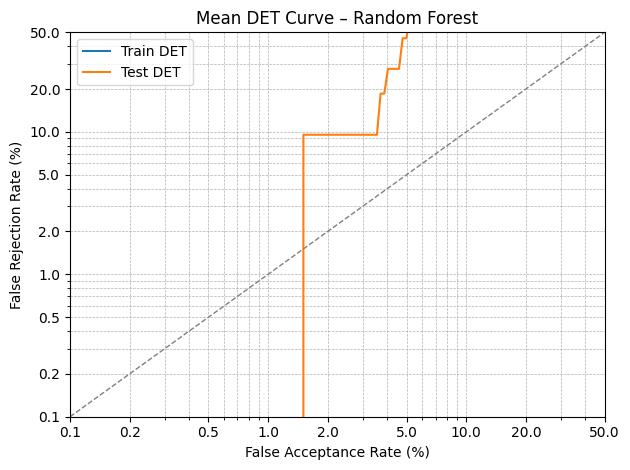

--- Decision Tree ---
seed 01 → train EER 0.000, test EER 0.628
seed 02 → train EER 0.000, test EER 0.570
seed 03 → train EER 0.000, test EER 0.549
seed 04 → train EER 0.000, test EER 0.646
seed 05 → train EER 0.000, test EER 0.819
seed 06 → train EER 0.000, test EER 0.632
seed 07 → train EER 0.000, test EER 0.556
seed 08 → train EER 0.000, test EER 0.592
seed 09 → train EER 0.000, test EER 0.625
seed 10 → train EER 0.000, test EER 0.596


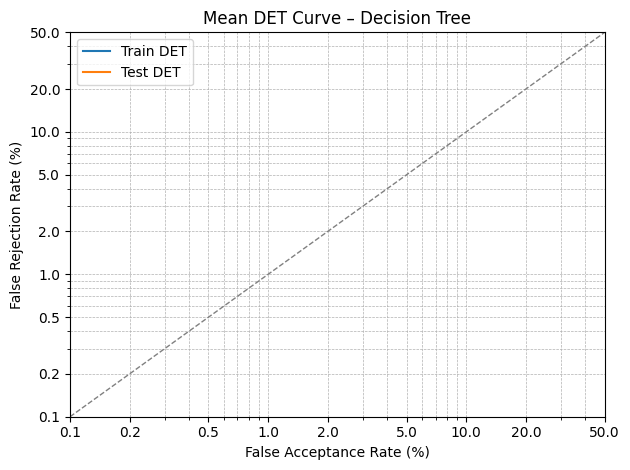

--- Logistic Regression ---
seed 01 → train EER 0.016, test EER 0.390
seed 02 → train EER 0.016, test EER 0.390
seed 03 → train EER 0.016, test EER 0.390
seed 04 → train EER 0.016, test EER 0.390
seed 05 → train EER 0.016, test EER 0.390
seed 06 → train EER 0.016, test EER 0.390
seed 07 → train EER 0.016, test EER 0.390
seed 08 → train EER 0.016, test EER 0.390
seed 09 → train EER 0.016, test EER 0.390
seed 10 → train EER 0.016, test EER 0.390


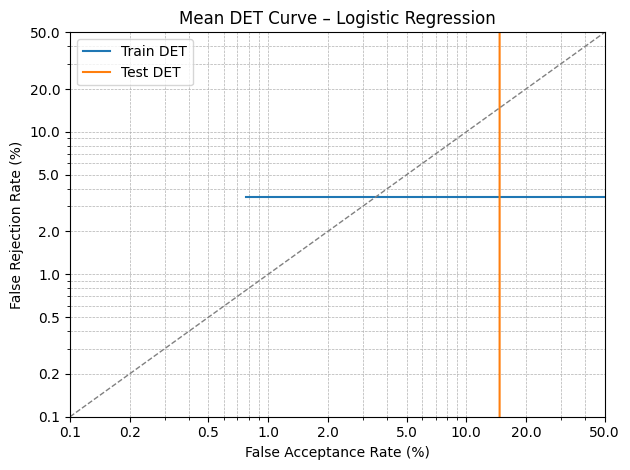

--- LightGBM ---
[LightGBM] [Info] Number of positive: 1140, number of negative: 129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163200
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 640
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.898345 -> initscore=2.178971
[LightGBM] [Info] Start training from score 2.178971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam

seed 01 → train EER 0.000, test EER 0.379
[LightGBM] [Info] Number of positive: 1140, number of negative: 129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163200
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 640
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.898345 -> initscore=2.178971
[LightGBM] [Info] Start training from score 2.178971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam

seed 02 → train EER 0.000, test EER 0.379
[LightGBM] [Info] Number of positive: 1140, number of negative: 129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163200
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 640
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.898345 -> initscore=2.178971
[LightGBM] [Info] Start training from score 2.178971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam

seed 03 → train EER 0.000, test EER 0.379
[LightGBM] [Info] Number of positive: 1140, number of negative: 129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163200
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 640
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.898345 -> initscore=2.178971
[LightGBM] [Info] Start training from score 2.178971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam

seed 04 → train EER 0.000, test EER 0.379
[LightGBM] [Info] Number of positive: 1140, number of negative: 129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163200
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 640
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.898345 -> initscore=2.178971
[LightGBM] [Info] Start training from score 2.178971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam

seed 05 → train EER 0.000, test EER 0.379
[LightGBM] [Info] Number of positive: 1140, number of negative: 129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163200
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 640
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.898345 -> initscore=2.178971
[LightGBM] [Info] Start training from score 2.178971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam

seed 06 → train EER 0.000, test EER 0.379
[LightGBM] [Info] Number of positive: 1140, number of negative: 129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163200
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 640
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.898345 -> initscore=2.178971
[LightGBM] [Info] Start training from score 2.178971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam

seed 07 → train EER 0.000, test EER 0.379
[LightGBM] [Info] Number of positive: 1140, number of negative: 129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163200
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 640
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.898345 -> initscore=2.178971
[LightGBM] [Info] Start training from score 2.178971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam

seed 08 → train EER 0.000, test EER 0.379
[LightGBM] [Info] Number of positive: 1140, number of negative: 129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163200
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 640
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.898345 -> initscore=2.178971
[LightGBM] [Info] Start training from score 2.178971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam

seed 09 → train EER 0.000, test EER 0.379
[LightGBM] [Info] Number of positive: 1140, number of negative: 129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163200
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 640
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.898345 -> initscore=2.178971
[LightGBM] [Info] Start training from score 2.178971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam

seed 10 → train EER 0.000, test EER 0.379


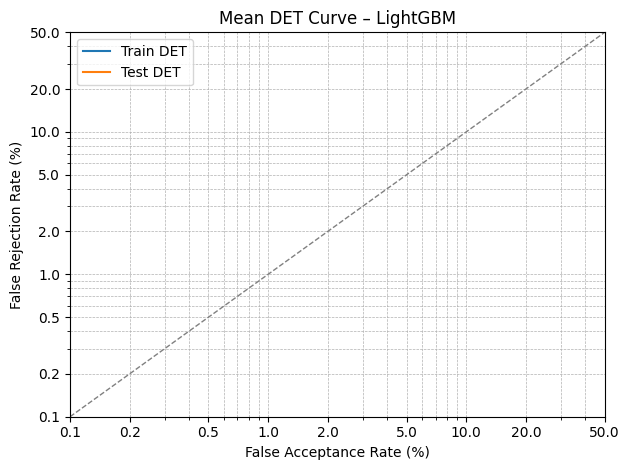

--- MLP (Neural Network) ---
seed 01 → train EER 0.000, test EER 0.357
seed 02 → train EER 0.000, test EER 0.336
seed 03 → train EER 0.000, test EER 0.336
seed 04 → train EER 0.000, test EER 0.336
seed 05 → train EER 0.000, test EER 0.332
seed 06 → train EER 0.000, test EER 0.332
seed 07 → train EER 0.000, test EER 0.325
seed 08 → train EER 0.000, test EER 0.343
seed 09 → train EER 0.000, test EER 0.329
seed 10 → train EER 0.000, test EER 0.329


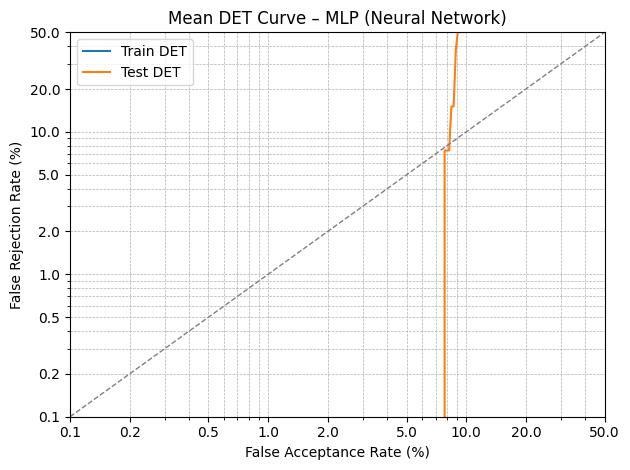

--- SVM ---
seed 01 → train EER 0.016, test EER 0.390
seed 02 → train EER 0.016, test EER 0.390
seed 03 → train EER 0.016, test EER 0.390
seed 04 → train EER 0.016, test EER 0.390
seed 05 → train EER 0.016, test EER 0.390
seed 06 → train EER 0.016, test EER 0.390
seed 07 → train EER 0.016, test EER 0.390
seed 08 → train EER 0.016, test EER 0.390
seed 09 → train EER 0.016, test EER 0.390
seed 10 → train EER 0.016, test EER 0.390


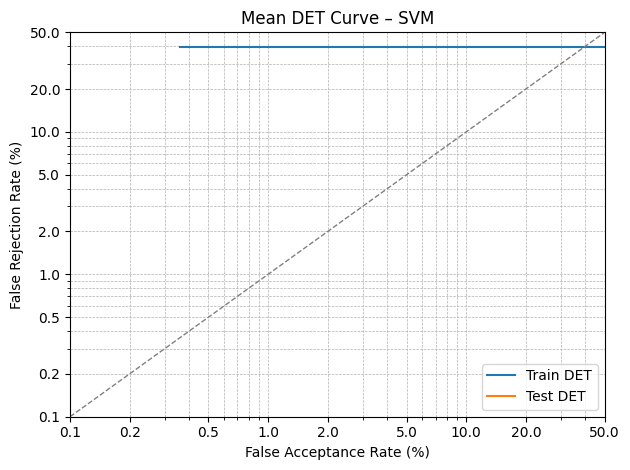

In [ ]:
features = ''
models = {
    "Random Forest":       RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree":       DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "LightGBM":            LGBMClassifier(random_state=42, verbose=-1, verbosity=-1),
    "MLP (Neural Network)":MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "SVM":                 SVC(probability=True, random_state=42)
}

print("Training and evaluating models with multiple seeds…\n")

for name, model in models.items():
    print(f"--- {name} ---")
    safe_name = name.replace(" ", "_").replace("(", "").replace(")", "")
    model_dir = os.path.join(base_dir, safe_name) + "_" + features
    os.makedirs(model_dir, exist_ok=True)

    all_fpr_tr, all_fnr_tr = [], []
    all_fpr_ts, all_fnr_ts = [], []

    for seed in SEEDS:
        model.set_params(random_state=seed)

        # Train
        t0 = time.time()
        model.fit(X_train_sub, y_train_sub)
        train_time = time.time() - t0

        # Eval TRAIN
        y_pred_tr = model.predict(X_train_sub)
        scores_tr = (model.predict_proba(X_train_sub)[:,1]
                     if hasattr(model, "predict_proba")
                     else model.decision_function(X_train_sub))
        fpr_tr, fnr_tr, _ = det_curve(y_train_sub, scores_tr)
        eer_tr = fpr_tr[np.nanargmin(np.abs(fnr_tr - fpr_tr))]

        # Eval TEST
        y_pred_ts = model.predict(X_test_sub)
        scores_ts = (model.predict_proba(X_test_sub)[:,1]
                     if hasattr(model, "predict_proba")
                     else model.decision_function(X_test_sub))
        fpr_ts, fnr_ts, _ = det_curve(y_test_sub, scores_ts)
        eer_ts = fpr_ts[np.nanargmin(np.abs(fnr_ts - fpr_ts))]

        # Append metrics, now including EER_train
        pd.DataFrame([{
            "Model": name,
            "Training Time (sec)": round(train_time, 2),
            "Accuracy": round(accuracy_score(y_test_sub, y_pred_ts), 4),
            "EER_train": round(eer_tr, 4),
            "EER": round(eer_ts, 4)
        }]).to_csv(test_csv, mode="a", header=False, index=False)

        print(f"seed {seed:02d} → train EER {eer_tr:.3f}, test EER {eer_ts:.3f}")

        # save model
        path = os.path.join(model_dir, f"model_seed_{seed:02d}.pkl")
        with open(path, "wb") as f:
            pickle.dump(model, f)

        # accumulate for mean DET
        all_fpr_tr.append(fpr_tr); all_fnr_tr.append(fnr_tr)
        all_fpr_ts.append(fpr_ts); all_fnr_ts.append(fnr_ts)

    # --- compute & plot mean DET as shown above ---
    all_fprs = np.hstack(all_fpr_tr + all_fpr_ts)
    min_pos, max_val = all_fprs[all_fprs>0].min(), all_fprs.max()
    grid = np.logspace(np.log10(min_pos), np.log10(max_val), num=100)

    interp_fnr_tr = np.vstack([np.interp(grid, f, fn) for f,fn in zip(all_fpr_tr, all_fnr_tr)])
    interp_fnr_ts = np.vstack([np.interp(grid, f, fn) for f,fn in zip(all_fpr_ts, all_fnr_ts)])
    mean_fnr_tr, mean_fnr_ts = interp_fnr_tr.mean(0), interp_fnr_ts.mean(0)

    plot_nist_det(
        grid, mean_fnr_tr,
        grid, mean_fnr_ts,
        title=f"Mean DET Curve – {name}"
    )